# QCBM and Multibasis QCBM

## Description

This notebook shows how to define and train a QCBM and a Multibasis QCBM wavefunctions.

## Defining an ansatz

Ansätze in qml-core are defined through layers. In this demo, we will use a `LineEntanglingLayerBuilder`, which creates layers of entangling gates between the first and the second qubit, the second and the third qubit, and so on. We will use an `EntanglingLayerAnsatz` which defines parameterised one-qubit rotations on each qubit, and then applies a layer of parameterised entangling gates between the qubits.

In [1]:
# !pip install pylatexenc
import torch as th
import numpy as np
from orquestra.qml.models.qcbm.layer_builders import LineEntanglingLayerBuilder
from orquestra.qml.models.qcbm.ansatze.alternating_entangling_layers import EntanglingLayerAnsatz
from orquestra.integrations.qiskit.noise import get_qiskit_noise_model
from orquestra.integrations.qiskit.simulator import QiskitWavefunctionSimulator


We are going to use the QCBM or multi-basis QCBM to generate bit strings of a given length.

In [45]:
bitstring_size = 7
n_layers = 2
entangling_layer_builder = LineEntanglingLayerBuilder(n_qubits=bitstring_size)
qcbm_ansatz = EntanglingLayerAnsatz(n_qubits=bitstring_size, n_layers=n_layers, entangling_layer_builder=entangling_layer_builder)
print(qcbm_ansatz.number_of_params)

20


In [8]:
qcbm_ansatz.parametrized_circuit

Circuit(operations=[RX(theta_0)(0), RX(theta_1)(1), RX(theta_2)(2), RX(theta_3)(3), RX(theta_4)(4), RX(theta_5)(5), RX(theta_6)(6), RX(theta_7)(7), RX(theta_8)(8), RX(theta_9)(9), RZ(theta_10)(0), RZ(theta_11)(1), RZ(theta_12)(2), RZ(theta_13)(3), RZ(theta_14)(4), RZ(theta_15)(5), RZ(theta_16)(6), RZ(theta_17)(7), RZ(theta_18)(8), RZ(theta_19)(9), XX(theta_20)(0,1), XX(theta_21)(1,2), XX(theta_22)(2,3), XX(theta_23)(3,4), XX(theta_24)(4,5), XX(theta_25)(5,6), XX(theta_26)(6,7), XX(theta_27)(7,8), XX(theta_28)(8,9)], n_qubits=10)

In [9]:
from orquestra.integrations.qiskit.conversions import (
    export_to_qiskit,
    import_from_qiskit,
)


In [10]:
qiskit_circ = export_to_qiskit(qcbm_ansatz.parametrized_circuit)

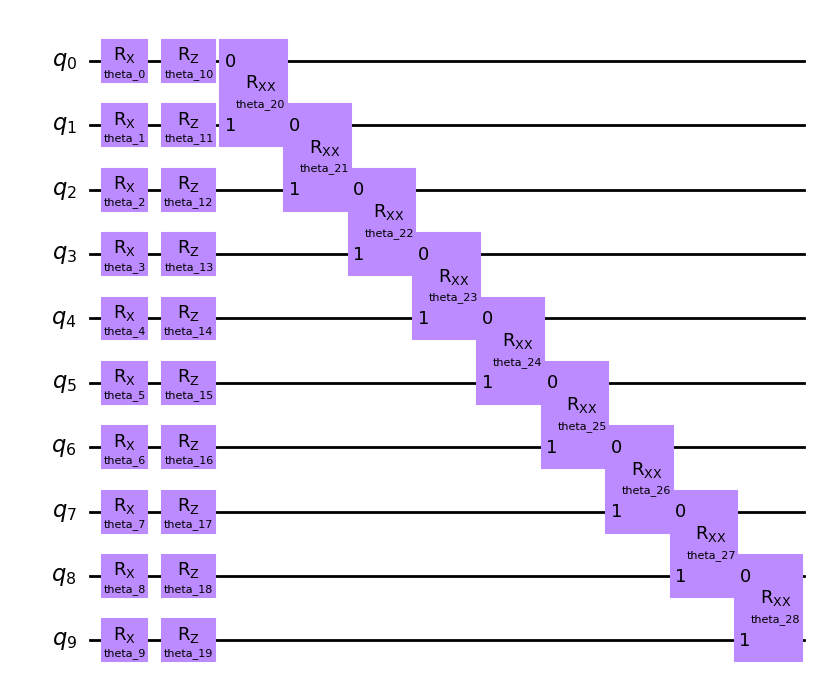

In [12]:
qiskit_circ.draw(output='mpl')

In [29]:
from qiskit import IBMQ
APIKEY = "de0f7bb6ce2c838ece97fd028c418ede21ae2ff0667c2499f3cd09f52b8c61f3649dce6d1c4fa1d77f034634635bbdf9e9461f1d2f75b77ec317e713c9bd45ce"


IBMQ.save_account(APIKEY)
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backends = provider.backends()

print("Available backends:")
for backend in backends:
    status = backend.status()
    is_operational = status.operational
    is_simulator = backend.configuration().simulator
    n_qubits = backend.configuration().n_qubits
    backend_name = backend.name()

    if is_operational and not is_simulator:
        print(f"{backend_name} (n_qubits={n_qubits})")

configrc.store_credentials:WARNING:2023-03-30 12:48:45,268: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2023-03-30 12:48:45,940: Credentials are already in use. The existing account in the session will be replaced.


Available backends:
ibmq_lima (n_qubits=5)
ibmq_belem (n_qubits=5)
ibmq_quito (n_qubits=5)
ibmq_jakarta (n_qubits=7)
ibmq_manila (n_qubits=5)
ibm_lagos (n_qubits=7)
ibm_nairobi (n_qubits=7)
ibm_perth (n_qubits=7)
ibm_oslo (n_qubits=7)


In [31]:
from orquestra.qml.models.qcbm import WavefunctionQCBM
from orquestra.integrations.qulacs.simulator import QulacsSimulator
from orquestra.opt.optimizers.scipy_optimizer import ScipyOptimizer



from orquestra.integrations.qiskit.noise import get_qiskit_noise_model
from orquestra.integrations.qiskit.simulator import QiskitWavefunctionSimulator
from orquestra.integrations.qiskit.runner import QiskitRunner
from orquestra.integrations.qiskit.runner import create_ibmq_runner



# We use just one iteration of the scipy optimizer. If we want more iterations, we will specify those as "epochs" when training.
# In other words, the optimizer will not be called directly to train the PQC: it will be called under the hood.



In [40]:


noise_model_, device_connectivity_ = get_qiskit_noise_model(device_name='ibmq_manila', api_token='81c0aa498ed56928a3ed16db662242aa5258767d26b157c5c8fefd43eff3849e56f9e688cdf0da40526133c033023ba648d8e9ea8ca5c1cbf1d52c92b060f9de')
backend = QiskitWavefunctionSimulator(qiskit_backend='ibm_lagos', noise_model=noise_model_, device_connectivity=None)
noiseless_backend = QiskitWavefunctionSimulator(qiskit_backend='statevector_simulator')



In [33]:
qiskit_runner = create_ibmq_runner(api_token='81c0aa498ed56928a3ed16db662242aa5258767d26b157c5c8fefd43eff3849e56f9e688cdf0da40526133c033023ba648d8e9ea8ca5c1cbf1d52c92b060f9de',backend_name="ibm_lagos")

In [46]:
device_connectivity_ 

[[0, 1], [1, 0], [1, 2], [2, 1], [2, 3], [3, 2], [3, 4], [4, 3]]

In [47]:

optimizer = ScipyOptimizer(method="Powell", options={"maxiter": 1})
qcbm = WavefunctionQCBM(ansatz=qcbm_ansatz, optimizer=optimizer, backend=backend, choices=(0, 1), use_efficient_training=False)

In [48]:
from orquestra.qml.data_loaders import CardinalityDataLoader

dataloader = CardinalityDataLoader(n_qubits=bitstring_size, cardinality=bitstring_size//2, batch_size=-1).shuffle(seed=1234)

In [49]:
from orquestra.qml.trainers import SimpleTrainer

trainer = SimpleTrainer()
result = trainer.train(qcbm, dataloader, n_epochs=40)

AttributeError: 'str' object has no attribute 'properties'